In [168]:
import os
from subprocess import call
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
from nilearn import plotting
from bids.layout import BIDSLayout
from multiprocessing.pool import Pool
import re
import notebook_functions as nf
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.patheffects as PathEffects
from itertools import product
import pickle

In [2]:
N_THREADS = 32
LSS_PATH = '../lssNoSignalScale/nibetaseries'
LSA_PATH = '../lsaNoSignalScale/nibetaseries'
FMRIPREP_PATH = '../fmriprep'
BIDS_PATH = '../..'
RESPONSE_ATLAS = '../data/overall_response_atlas.nii.gz'
RESPONSE_LUT = '../data/overall_response.tsv'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'
SCHAEFER_ATLAS = '../data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii.gz'
SCHAEFER_LUT = '../data/schaefer_parcel-400_network-17.tsv'

In [116]:
def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [3]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

,bids_name,aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,...,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr,task,participant_id
0,sub-GE120001_ses-pre_task-fauxbold_bold,0.001063,0.006351,2,16.187316,1.198663,1.010760,0.448331,3009467.75,0.103818,...,232.520432,1381.902222,1410.488159,29195.0,837.753119,1812.366785,297.530945,64.075073,fauxbold,GE120001
3,sub-GE120001_ses-pre_task-taskswitch_bold,0.003942,0.005572,2,15.734272,1.148948,0.957532,0.450887,1364181.25,0.138379,...,216.930939,1391.725708,1421.432861,29084.0,868.629898,1788.999225,284.924835,72.902779,taskswitch,GE120001
4,sub-GE120002_ses-pre_task-fauxbold_bold,0.002056,0.010868,1,17.975215,1.024274,1.143355,0.432753,3026978.75,0.227028,...,225.343140,1283.572998,1322.169800,27338.0,738.498715,1686.504254,287.157501,47.578674,fauxbold,GE120002
7,sub-GE120002_ses-pre_task-taskswitch_bold,0.002134,0.004827,1,16.918552,1.176876,0.990735,0.431836,4213331.00,0.169619,...,229.552505,1292.104004,1334.634033,27340.0,734.595834,1700.930396,292.718201,71.898445,taskswitch,GE120002
8,sub-GE120003_ses-pre_task-fauxbold_bold,0.003094,0.018135,1,38.223070,1.116687,0.909317,0.393451,2381240.50,0.577373,...,246.342178,1247.227295,1309.490601,23125.0,595.968738,1648.415723,314.057434,31.255548,fauxbold,GE120003


In [4]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False
    otherwise.
    modified from nipype:
    https://github.com/nipy/nipype/blob/b62d80/nipype/algorithms/confounds.py#L1129
    Parameters
    ----------
    points: nparray
        an numobservations by numdimensions numpy array of observations
    thresh: float
        the modified z-score to use as a threshold. Observations with
        a modified z-score (based on the median absolute deviation) greater
        than this value will be classified as outliers.
    Returns
    -------
        A bolean mask, of size numobservations-length array.
    .. note:: References
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    import numpy as np

    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [5]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [6]:
lss_layout = BIDSLayout(LSS_PATH, validate=False, config=['bids', 'derivatives'])
lsa_layout = BIDSLayout(LSA_PATH, validate=False, config=['bids', 'derivatives'])

In [7]:
ent = lss_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [8]:
lsa_betas = nf.get_layout_objects(lsa_layout, trialtypes=['single', 'repeat', 'switch'], 
                      suffix="betaseries", extension="nii.gz", task="taskswitch",
                      subject=good_participants)
lsa_residuals = lsa_layout.get(task="taskswitch", desc='residuals', subject=good_participants)

lss_betas = nf.get_layout_objects(lss_layout, trialtypes=['single', 'repeat', 'switch'], 
                      suffix="betaseries", extension="nii.gz", task="taskswitch",
                    subject=good_participants)
lss_residuals = lsa_layout.get(task="taskswitch", desc='residuals', subject=good_participants)

In [9]:
response_masker = NiftiLabelsMasker(RESPONSE_ATLAS)
response_lut = pd.read_csv(RESPONSE_LUT, sep='\t')
response_lut

,regions,index
0,1,1
1,1a,2
2,1b,3
3,1c,4
4,2,5
5,2a,6
6,2b,7
7,2c,8
8,3,9
9,3a,10


In [10]:
schaefer_masker = NiftiLabelsMasker(SCHAEFER_ATLAS)
schaefer_lut = pd.read_csv(SCHAEFER_LUT, sep='\t')

In [11]:
schaefer_lut

,regions,index
0,LH-VisCent-ExStr_1,1
1,LH-VisCent-ExStr_2,2
2,LH-VisCent-ExStr_3,3
3,LH-VisCent-ExStr_4,4
4,LH-VisCent-ExStr_5,5
5,LH-VisCent-ExStr_6,6
6,LH-VisCent-ExStr_7,7
7,LH-VisCent-ExStr_8,8
8,LH-VisCent-ExStr_9,9
9,LH-VisCent-ExStr_10,10


In [12]:
def process_participant_betas(layout, lsa_layout, participant, atlas, task):
    # get the betas for the relavent trial types
    betas = nf.get_layout_objects(
        layout, trialtypes=['single', 'repeat', 'switch'], 
        suffix="betaseries", extension="nii.gz", task=task,
        subject=participant)
    
    # get the residual from LSA no matter what since the residual comes from one model
    # (as opposed to the average of residuals that LSS returns)
    residual = lsa_layout.get(task=task, desc='residuals', subject=participant)
    
    # get the average time/beta series from each region of interest
    masker = NiftiLabelsMasker(atlas)
    
    # get the betas for all trial types
    all_betas = [masker.fit_transform(betas[cond][0].path) for cond in ['single', 'repeat', 'switch']]
    
    # filter the beta series from outliers
    filtered_betas = [beta_data[~is_outlier(beta_data)] for beta_data in all_betas]
    
    # get the mean amplitude (across trial types) for each region of interest
    amplitude_betas = np.nanmean(np.array([np.nanmedian(np.abs(beta_data), axis=0) for beta_data in filtered_betas]), axis=0)
    
    # get the mean standard deviation (across trial types) for each region of interest
    std_betas = np.nanmean(np.array([np.nanstd(beta_data, axis=0) for beta_data in filtered_betas]), axis=0)
    
    # get the standard deviation of the noise for each region of interest
    std_noise = np.nanstd(masker.fit_transform(residual[0].path), axis=0)
    
    # contrast to noise ratio
    cnr = amplitude_betas / std_noise
    
    # contrast variance to noise ratio
    cvnr = std_betas / std_noise
    
    return cnr, cvnr
    

In [13]:
cnr_activation_collector = {}
cvnr_activation_collector = {}
for method, ly in [("lsa", lsa_layout), ("lss", lss_layout)]:
    cnr_activation_collector[method] = {}
    cvnr_activation_collector[method] = {}
    for participant in good_participants:
        cnr, cvnr = process_participant_betas(ly, lsa_layout, participant, RESPONSE_ATLAS, "taskswitch")
        cnr_activation_collector[method][participant] = cnr
        cvnr_activation_collector[method][participant] = cvnr

In [14]:
cvnr_activation_lsa_df = pd.DataFrame.from_dict(cvnr_activation_collector['lsa'], orient='index', columns=response_lut['regions'])
cnr_activation_lsa_df = pd.DataFrame.from_dict(cnr_activation_collector['lsa'], orient='index', columns=response_lut['regions'])
cvnr_activation_lss_df = pd.DataFrame.from_dict(cvnr_activation_collector['lss'], orient='index', columns=response_lut['regions'])
cnr_activation_lss_df = pd.DataFrame.from_dict(cnr_activation_collector['lss'], orient='index', columns=response_lut['regions'])

In [15]:
cvnr_activation_lsa_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,1.493791,0.698882,0.603026,0.957895,1.400787,1.642858,3.531632
1a,40.0,1.446815,0.465670,0.713626,1.191430,1.335361,1.575823,3.183634
1b,40.0,1.646220,0.709622,0.531828,1.032060,1.598571,1.994703,3.565423
1c,40.0,1.937784,1.034760,0.560799,1.378113,1.650934,2.272146,6.161914
2,40.0,2.856246,1.711651,0.768488,1.550718,2.468440,3.520120,7.791657
2a,40.0,1.378601,0.835340,0.431093,0.937165,1.223010,1.490604,4.598309
2b,40.0,3.133568,1.589274,1.402476,2.140411,2.601349,3.407890,8.884598
2c,40.0,1.534577,1.166180,0.330930,0.944795,1.233039,1.747221,6.610168
3,40.0,2.540929,1.161353,0.753146,1.526721,2.348683,3.445912,5.595266


In [16]:
cvnr_act_lsa_mean = cvnr_activation_lsa_df.describe().T['mean'].mean()
cvnr_act_lsa_max = cvnr_activation_lsa_df.describe().T['mean'].max()
print("AVNR (activation, lsa) Mean: {}".format(cvnr_act_lsa_mean))
print("AVNR (activation, lsa) Max: {}".format(cvnr_act_lsa_max))

AVNR (activation, lsa) Mean: 2.1534168396357405
AVNR (activation, lsa) Max: 3.260426728745448


In [17]:
cnr_activation_lsa_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,1.013019,0.486004,0.397652,0.702270,0.854607,1.182677,2.830594
1a,40.0,1.010043,0.330937,0.500087,0.788534,0.994951,1.118403,2.079824
1b,40.0,1.103887,0.452523,0.417274,0.780378,1.009616,1.259987,2.647754
1c,40.0,1.332659,0.653980,0.418005,0.903863,1.146819,1.656428,3.754581
2,40.0,1.954379,1.135411,0.592758,1.104842,1.754123,2.306997,5.183483
2a,40.0,0.923844,0.546594,0.321112,0.654297,0.823290,1.006208,3.348192
2b,40.0,2.176973,1.152482,0.936605,1.527462,1.821859,2.433338,6.545389
2c,40.0,0.990283,0.700150,0.225749,0.625231,0.800554,1.119164,3.540455
3,40.0,1.725172,0.738436,0.570616,1.072489,1.550546,2.323591,3.622044


In [18]:
cnr_act_lsa_mean = cnr_activation_lsa_df.describe().T['mean'].mean()
cnr_act_lsa_max = cnr_activation_lsa_df.describe().T['mean'].max()
print("CNR (activation, lsa) Mean: {}".format(cnr_act_lsa_mean))
print("CNR (activation, lsa) Max: {}".format(cnr_act_lsa_max))

CNR (activation, lsa) Mean: 1.4151391926183445
CNR (activation, lsa) Max: 2.1769726814544077


In [19]:
cvnr_activation_lss_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,0.991699,0.459659,0.402916,0.672556,0.839920,1.197684,2.342959
1a,40.0,1.010297,0.383920,0.535665,0.765383,0.897015,1.115829,2.503862
1b,40.0,1.042829,0.337555,0.300165,0.804933,1.016416,1.264432,1.740425
1c,40.0,1.168353,0.445155,0.348067,0.903559,1.083729,1.431145,2.441960
2,40.0,1.862532,1.030380,0.469624,1.108758,1.619184,2.312283,4.484069
2a,40.0,0.913721,0.513803,0.289238,0.574667,0.796160,1.099487,2.916147
2b,40.0,2.115082,0.981789,1.050287,1.374604,1.792286,2.535464,5.011984
2c,40.0,1.036974,0.804704,0.213250,0.634449,0.833476,1.129677,4.723067
3,40.0,1.713144,0.916288,0.513759,1.101005,1.459309,2.359862,5.240617


In [20]:
cvnr_act_lss_mean = cvnr_activation_lss_df.describe().T['mean'].mean()
cvnr_act_lss_max = cvnr_activation_lss_df.describe().T['mean'].max()
print("AVNR (activation, lss) Mean: {}".format(cvnr_act_lss_mean))
print("AVNR (activation, lss) Max: {}".format(cvnr_act_lss_max))

AVNR (activation, lss) Mean: 1.4212443111032529
AVNR (activation, lss) Max: 2.177198372941991


In [21]:
cnr_activation_lss_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,0.733415,0.328015,0.323872,0.501764,0.608512,0.873120,1.562037
1a,40.0,0.773206,0.260932,0.406581,0.611929,0.700751,0.877462,1.678054
1b,40.0,0.697209,0.254617,0.216813,0.552763,0.689467,0.783594,1.734160
1c,40.0,0.857797,0.375526,0.245431,0.623866,0.778822,0.951853,2.261710
2,40.0,1.364370,0.749001,0.328800,0.768002,1.139188,1.655693,3.222138
2a,40.0,0.742210,0.594321,0.198677,0.455783,0.588144,0.756345,3.666304
2b,40.0,1.581858,0.806183,0.621146,1.021184,1.408843,1.820071,3.944619
2c,40.0,0.703025,0.492417,0.124908,0.412172,0.588418,0.803159,2.284423
3,40.0,1.179387,0.688070,0.382260,0.718691,1.001191,1.530680,4.435945


In [22]:
cnr_act_lss_mean = cnr_activation_lss_df.describe().T['mean'].mean()
cnr_act_lss_max = cnr_activation_lss_df.describe().T['mean'].max()
print("CNR (activation, lss) Mean: {}".format(cnr_act_lss_mean))
print("CNR (activation, lss) Max: {}".format(cnr_act_lss_max))

CNR (activation, lss) Mean: 0.9895698447616426
CNR (activation, lss) Max: 1.5818575998173128


In [23]:
cnr_schaefer_collector = {}
cvnr_schaefer_collector = {}
for method, ly in [("lsa", lsa_layout), ("lss", lss_layout)]:
    cnr_schaefer_collector[method] = {}
    cvnr_schaefer_collector[method] = {}
    for participant in good_participants:
        cnr, cvnr = process_participant_betas(ly, lsa_layout, participant, SCHAEFER_ATLAS, "taskswitch")
        cnr_schaefer_collector[method][participant] = cnr
        cvnr_schaefer_collector[method][participant] = cvnr

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid valu

In [24]:
cvnr_schaefer_lsa_df = pd.DataFrame.from_dict(cvnr_schaefer_collector['lsa'], orient='index', columns=schaefer_lut['regions'])
cnr_schaefer_lsa_df = pd.DataFrame.from_dict(cnr_schaefer_collector['lsa'], orient='index', columns=schaefer_lut['regions'])
cvnr_schaefer_lss_df = pd.DataFrame.from_dict(cvnr_schaefer_collector['lss'], orient='index', columns=schaefer_lut['regions'])
cnr_schaefer_lss_df = pd.DataFrame.from_dict(cnr_schaefer_collector['lss'], orient='index', columns=schaefer_lut['regions'])

In [25]:
print("AVNR (schaefer, lsa) Mean: {}".format(cvnr_schaefer_lsa_df.mean().mean()))
print("AVNR (schaefer, lsa) Max: {}".format(cvnr_schaefer_lsa_df.mean().max()))

AVNR (schaefer, lsa) Mean: 1.5401114183170141
AVNR (schaefer, lsa) Max: 3.6112200244326873


In [26]:
print("CNR (schaefer, lsa) Mean: {}".format(cnr_schaefer_lsa_df.mean().mean()))
print("CNR (schaefer, lsa) Max: {}".format(cnr_schaefer_lsa_df.mean().max()))

CNR (schaefer, lsa) Mean: 1.020134793837807
CNR (schaefer, lsa) Max: 2.480575385177624


In [27]:
print("AVNR (schaefer, lss) Mean: {}".format(cvnr_schaefer_lss_df.mean().mean()))
print("AVNR (schaefer, lss) Max: {}".format(cvnr_schaefer_lss_df.mean().max()))

AVNR (schaefer, lss) Mean: 1.033641100411185
AVNR (schaefer, lss) Max: 2.327435377186426


In [28]:
print("CNR (schaefer, lss) Mean: {}".format(cnr_schaefer_lss_df.mean().mean()))
print("CNR (schaefer, lss) Max: {}".format(cnr_schaefer_lss_df.mean().max()))

CNR (schaefer, lss) Mean: 0.7137942709185943
CNR (schaefer, lss) Max: 1.8056619546708372


## Which regions have a CNR/AVNR greater than 2

In [29]:
cnr_schaefer_lsa_df.describe().T[cnr_schaefer_lsa_df.describe().T['mean'] > 2]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-VisCent-ExStr_3,40.0,2.142805,0.889369,0.388851,1.426232,1.965783,2.806570,4.851932
LH-VisCent-ExStr_5,40.0,2.043847,1.036603,0.736595,1.283927,1.723797,2.467863,4.980572
LH-VisCent-ExStr_7,40.0,2.480575,0.889299,0.919602,1.788447,2.366594,3.091492,5.074552
LH-VisPeri-ExStrSup_6,40.0,2.056303,1.132457,0.605926,1.268031,1.654681,2.861608,4.707227
LH-Limbic-OFC_3,40.0,2.080335,1.024674,0.562745,1.393618,1.827620,2.418613,5.124079
LH-Limbic-TempPole_2,40.0,2.153894,0.779840,0.881210,1.568716,2.122801,2.515156,3.945719
RH-VisCent-ExStr_2,40.0,2.063646,1.049891,0.489843,1.259953,1.760740,2.746714,5.011490
RH-VisCent-ExStr_4,40.0,2.012342,0.936878,0.734518,1.384012,1.697575,2.582042,4.131340
RH-VisCent-ExStr_5,40.0,2.242726,1.047660,0.948773,1.388900,1.851100,2.884884,4.834418


In [30]:
cvnr_schaefer_lsa_df.describe().T[cvnr_schaefer_lsa_df.describe().T['mean'] > 2]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-VisCent-ExStr_1,40.0,2.225244,1.052452,0.515402,1.527926,2.059228,2.720687,5.936769
LH-VisCent-ExStr_3,40.0,3.111485,1.415272,0.399459,2.261057,2.774938,3.761216,8.059678
LH-VisCent-ExStr_4,40.0,2.960881,1.431254,0.663924,1.997563,2.545178,4.002891,6.651078
LH-VisCent-ExStr_5,40.0,2.938231,1.301927,0.849461,1.950814,2.512583,3.736111,5.821395
LH-VisCent-ExStr_7,40.0,3.611220,1.357423,1.403325,2.617554,3.350307,4.614512,6.710901
LH-VisCent-ExStr_9,40.0,2.375638,1.117671,0.935289,1.633447,2.156104,3.014627,6.013707
LH-VisCent-ExStr_11,40.0,2.212208,1.235059,0.509146,1.144606,1.871985,3.023468,4.656975
LH-VisPeri-ExStrSup_4,40.0,2.444217,1.392159,0.710364,1.406188,2.235060,3.049554,7.506065
LH-VisPeri-ExStrSup_6,40.0,2.986064,1.530720,0.998357,1.828213,2.385981,3.979158,6.468668


In [31]:
cnr_schaefer_lss_df.describe().T[cnr_schaefer_lss_df.describe().T['mean'] > 1.5]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-VisCent-ExStr_3,40.0,1.527580,0.689923,0.286017,1.047769,1.360714,2.015887,3.114430
LH-VisCent-ExStr_5,40.0,1.531651,0.880765,0.549806,0.929155,1.338333,1.716236,4.657903
LH-VisCent-ExStr_7,40.0,1.652026,0.644615,0.582454,1.259813,1.638335,1.990500,3.748170
RH-VisCent-ExStr_5,40.0,1.747216,0.971562,0.719213,1.038454,1.475445,1.987906,4.944616
RH-VisCent-ExStr_6,40.0,1.805662,0.884713,0.671675,1.214399,1.552847,2.074230,5.090316
RH-VisCent-ExStr_7,40.0,1.534135,0.711143,0.651493,0.940161,1.366118,1.894513,3.286731


In [32]:
best_lsa_cnr = set(cnr_schaefer_lsa_df.describe().T.nlargest(25, 'mean').index)
best_lss_cnr = set(cnr_schaefer_lss_df.describe().T.nlargest(25, 'mean').index)
overall_best_cnr = best_lsa_cnr.intersection(best_lss_cnr)
len(overall_best_cnr)

20

In [33]:
overall_best_cnr

{'LH-ContA-IPS_1',
 'LH-DefaultA-PCC_6',
 'LH-DefaultC-PHC_1',
 'LH-Limbic-OFC_3',
 'LH-Limbic-TempPole_2',
 'LH-Limbic-TempPole_7',
 'LH-VisCent-ExStr_3',
 'LH-VisCent-ExStr_4',
 'LH-VisCent-ExStr_5',
 'LH-VisCent-ExStr_7',
 'LH-VisPeri-ExStrSup_6',
 'RH-Limbic-OFC_3',
 'RH-Limbic-OFC_5',
 'RH-Limbic-TempPole_5',
 'RH-VisCent-ExStr_2',
 'RH-VisCent-ExStr_4',
 'RH-VisCent-ExStr_5',
 'RH-VisCent-ExStr_6',
 'RH-VisCent-ExStr_7',
 'RH-VisCent-ExStr_9'}

In [34]:
with open('outputs/schaefer_best_cnr.pkl', 'wb') as fp:
    pickle.dump(overall_best_cnr, fp)

## Null Data

In [35]:
cnr_fb_activation_collector = {}
cvnr_fb_activation_collector = {}
for method, ly in [("lsa", lsa_layout), ("lss", lss_layout)]:
    cnr_fb_activation_collector[method] = {}
    cvnr_fb_activation_collector[method] = {}
    for participant in good_participants:
        cnr, cvnr = process_participant_betas(ly, lsa_layout, participant, RESPONSE_ATLAS, "fauxbold")
        cnr_fb_activation_collector[method][participant] = cnr
        cvnr_fb_activation_collector[method][participant] = cvnr

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [36]:
cvnr_fb_activation_lsa_df = pd.DataFrame.from_dict(cvnr_fb_activation_collector['lsa'], orient='index', columns=response_lut['regions'])
cnr_fb_activation_lsa_df = pd.DataFrame.from_dict(cnr_fb_activation_collector['lsa'], orient='index', columns=response_lut['regions'])
cvnr_fb_activation_lss_df = pd.DataFrame.from_dict(cvnr_fb_activation_collector['lss'], orient='index', columns=response_lut['regions'])
cnr_fb_activation_lss_df = pd.DataFrame.from_dict(cnr_fb_activation_collector['lss'], orient='index', columns=response_lut['regions'])

In [37]:
cvnr_fb_activation_lsa_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,1.531241,0.888442,0.501142,0.826408,1.252008,2.163570,3.875098
1a,40.0,1.480820,0.814145,0.506814,0.962370,1.294526,1.668585,4.015378
1b,40.0,1.775492,1.114036,0.612653,0.992065,1.516692,2.121374,5.758200
1c,40.0,1.937829,1.148681,0.572022,1.140003,1.749522,2.511507,6.296894
2,40.0,3.104323,1.796544,0.602317,1.892906,2.607745,4.125014,7.271945
2a,40.0,1.912305,1.642434,0.336038,0.974321,1.426441,1.992005,7.325638
2b,40.0,3.921909,2.185228,1.129530,2.037120,3.333264,5.652824,8.741490
2c,40.0,2.289021,1.993894,0.386906,0.887855,1.655594,3.161054,10.243802
3,39.0,2.485132,1.129165,0.844165,1.781497,2.233910,2.736719,6.275171


In [38]:
cvnr_fb_act_lsa_mean = cvnr_fb_activation_lsa_df.describe().T['mean'].mean()
cvnr_fb_act_lsa_max = cvnr_fb_activation_lsa_df.describe().T['mean'].max()
print("AVNR (activation, lsa) Mean: {}".format(cvnr_fb_act_lsa_mean))
print("AVNR (activation, lsa) Max: {}".format(cvnr_fb_act_lsa_max))

AVNR (activation, lsa) Mean: 2.299087405532894
AVNR (activation, lsa) Max: 3.921908920372142


In [39]:
cnr_activation_lsa_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,1.013019,0.486004,0.397652,0.702270,0.854607,1.182677,2.830594
1a,40.0,1.010043,0.330937,0.500087,0.788534,0.994951,1.118403,2.079824
1b,40.0,1.103887,0.452523,0.417274,0.780378,1.009616,1.259987,2.647754
1c,40.0,1.332659,0.653980,0.418005,0.903863,1.146819,1.656428,3.754581
2,40.0,1.954379,1.135411,0.592758,1.104842,1.754123,2.306997,5.183483
2a,40.0,0.923844,0.546594,0.321112,0.654297,0.823290,1.006208,3.348192
2b,40.0,2.176973,1.152482,0.936605,1.527462,1.821859,2.433338,6.545389
2c,40.0,0.990283,0.700150,0.225749,0.625231,0.800554,1.119164,3.540455
3,40.0,1.725172,0.738436,0.570616,1.072489,1.550546,2.323591,3.622044


In [40]:
cnr_fb_act_lsa_mean = cnr_fb_activation_lsa_df.describe().T['mean'].mean()
cnr_fb_act_lsa_max = cnr_fb_activation_lsa_df.describe().T['mean'].max()
print("CNR (activation, lsa) Mean: {}".format(cnr_fb_act_lsa_mean))
print("CNR (activation, lsa) Max: {}".format(cnr_fb_act_lsa_max))

CNR (activation, lsa) Mean: 1.4390703618158505
CNR (activation, lsa) Max: 2.404241831443192


In [41]:
cvnr_fb_activation_lss_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,1.093812,0.618081,0.361524,0.635927,0.891463,1.400147,2.870566
1a,40.0,1.017806,0.480427,0.429479,0.658842,0.982984,1.201498,2.467200
1b,40.0,1.251060,0.710503,0.458686,0.805342,0.989711,1.365941,3.376084
1c,40.0,1.400269,0.819532,0.405291,0.745039,1.322452,1.593089,4.060563
2,40.0,2.033339,1.099597,0.529957,1.296309,1.717202,2.780100,4.346362
2a,40.0,1.282895,0.928535,0.301219,0.730280,0.990719,1.550313,4.554269
2b,40.0,2.559940,1.269381,0.852015,1.511663,2.340802,3.201234,5.137722
2c,40.0,1.517596,1.161042,0.307482,0.692862,1.122433,2.014449,5.953109
3,39.0,1.628559,0.744057,0.701231,1.206842,1.458361,1.784228,3.986755


In [42]:
cvnr_fb_act_lss_mean = cvnr_fb_activation_lss_df.describe().T['mean'].mean()
cvnr_fb_act_lss_max = cvnr_fb_activation_lss_df.describe().T['mean'].max()
print("AVNR (activation, lss) Mean: {}".format(cvnr_fb_act_lss_mean))
print("AVNR (activation, lss) Max: {}".format(cvnr_fb_act_lss_max))

AVNR (activation, lss) Mean: 1.5610111167547582
AVNR (activation, lss) Max: 2.5599404082058257


In [43]:
cnr_fb_activation_lss_df.describe().T

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
1,40.0,0.682066,0.389179,0.231885,0.405832,0.573547,0.825308,1.730815
1a,40.0,0.658471,0.325503,0.247426,0.382678,0.646714,0.831948,1.714657
1b,40.0,0.719575,0.337575,0.316274,0.457662,0.649316,0.883352,1.603972
1c,40.0,0.827038,0.431474,0.225145,0.460721,0.773858,1.017102,2.044981
2,40.0,1.380104,0.764090,0.326513,0.887649,1.151761,1.845020,3.255375
2a,40.0,0.852889,0.604296,0.228714,0.478966,0.673947,1.047520,2.772388
2b,40.0,1.631971,0.819294,0.497697,0.952884,1.379486,2.214019,3.072260
2c,40.0,0.944310,0.710354,0.175040,0.470049,0.739163,1.233445,3.252645
3,39.0,1.052461,0.422653,0.528138,0.781415,0.959373,1.244888,2.542035


In [44]:
cnr_fb_act_lss_mean = cnr_fb_activation_lss_df.describe().T['mean'].mean()
cnr_fb_act_lss_max = cnr_fb_activation_lss_df.describe().T['mean'].max()
print("CNR (activation, lss) Mean: {}".format(cnr_fb_act_lss_mean))
print("CNR (activation, lss) Max: {}".format(cnr_fb_act_lss_max))

CNR (activation, lss) Mean: 0.995336962673852
CNR (activation, lss) Max: 1.6319706623899577


In [45]:
cnr_fb_schaefer_collector = {}
cvnr_fb_schaefer_collector = {}
for method, ly in [("lsa", lsa_layout), ("lss", lss_layout)]:
    cnr_fb_schaefer_collector[method] = {}
    cvnr_fb_schaefer_collector[method] = {}
    for participant in good_participants:
        cnr, cvnr = process_participant_betas(ly, lsa_layout, participant, SCHAEFER_ATLAS, "fauxbold")
        cnr_fb_schaefer_collector[method][participant] = cnr
        cvnr_fb_schaefer_collector[method][participant] = cvnr

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid valu

In [46]:
cvnr_fb_schaefer_lsa_df = pd.DataFrame.from_dict(cvnr_fb_schaefer_collector['lsa'], orient='index', columns=schaefer_lut['regions'])
cnr_fb_schaefer_lsa_df = pd.DataFrame.from_dict(cnr_fb_schaefer_collector['lsa'], orient='index', columns=schaefer_lut['regions'])
cvnr_fb_schaefer_lss_df = pd.DataFrame.from_dict(cvnr_fb_schaefer_collector['lss'], orient='index', columns=schaefer_lut['regions'])
cnr_fb_schaefer_lss_df = pd.DataFrame.from_dict(cnr_fb_schaefer_collector['lss'], orient='index', columns=schaefer_lut['regions'])

In [47]:
print("AVNR (schaefer, lsa) Mean: {}".format(cvnr_fb_schaefer_lsa_df.mean().mean()))
print("AVNR (schaefer, lsa) Max: {}".format(cvnr_fb_schaefer_lsa_df.mean().max()))

AVNR (schaefer, lsa) Mean: 1.9452340296327748
AVNR (schaefer, lsa) Max: 4.496183537891773


In [48]:
print("CNR (schaefer, lsa) Mean: {}".format(cnr_fb_schaefer_lsa_df.mean().mean()))
print("CNR (schaefer, lsa) Max: {}".format(cnr_fb_schaefer_lsa_df.mean().max()))

CNR (schaefer, lsa) Mean: 1.2239513303120504
CNR (schaefer, lsa) Max: 2.946738351069926


In [49]:
print("AVNR (schaefer, lss) Mean: {}".format(cvnr_fb_schaefer_lss_df.mean().mean()))
print("AVNR (schaefer, lss) Max: {}".format(cvnr_fb_schaefer_lss_df.mean().max()))

AVNR (schaefer, lss) Mean: 1.3541887884218409
AVNR (schaefer, lss) Max: 3.1015894160663526


In [50]:
print("CNR (schaefer, lss) Mean: {}".format(cnr_fb_schaefer_lss_df.mean().mean()))
print("CNR (schaefer, lss) Max: {}".format(cnr_fb_schaefer_lss_df.mean().max()))

CNR (schaefer, lss) Mean: 0.8753290326540158
CNR (schaefer, lss) Max: 2.055478249517477


## Which regions have a CNR/AVNR greater than 2

In [51]:
cnr_fb_schaefer_lsa_df.describe().T[cnr_fb_schaefer_lsa_df.describe().T['mean'] > 2]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-VisCent-ExStr_5,40.0,2.054817,1.307390,0.452648,1.107536,1.809555,2.558522,5.961098
LH-VisCent-ExStr_7,40.0,2.353483,1.521135,0.407304,1.123195,2.087242,3.401450,7.643696
LH-VisPeri-ExStrSup_6,40.0,2.126581,1.808407,0.311944,0.884584,1.735853,2.655479,10.000331
LH-Limbic-OFC_3,40.0,2.480661,1.582446,0.465334,1.373810,2.135279,3.321318,7.097265
LH-Limbic-TempPole_2,40.0,2.220343,0.862626,0.465494,1.494763,2.246198,2.715006,4.057188
LH-ContA-IPS_1,40.0,2.038346,1.326783,0.319277,1.040331,1.661316,2.506943,5.732609
LH-ContB-IPL_1,40.0,2.043483,1.287566,0.403722,1.068422,1.890237,2.554347,5.354406
LH-ContC-pCun_1,40.0,2.112446,1.401953,0.419907,0.765996,1.884409,3.017239,5.670616
LH-DefaultA-IPL_1,40.0,2.095702,1.437125,0.399633,0.998209,1.452736,3.001882,5.801976


In [52]:
cvnr_fb_schaefer_lsa_df.describe().T[cvnr_fb_schaefer_lsa_df.describe().T['mean'] > 2]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-VisCent-ExStr_1,40.0,2.236625,1.481161,0.580394,1.286575,1.750323,2.611833,7.206342
LH-VisCent-ExStr_3,40.0,2.973215,1.751188,0.693552,1.649408,2.684185,3.864757,7.694971
LH-VisCent-ExStr_4,40.0,2.562678,1.943876,0.555662,1.289730,2.229687,3.364538,11.511108
LH-VisCent-ExStr_5,40.0,3.341979,2.337601,0.764107,1.608081,2.729569,4.191765,12.260483
LH-VisCent-ExStr_6,40.0,2.992338,2.382293,0.663556,1.364474,2.234626,3.737386,10.992914
LH-VisCent-ExStr_7,40.0,3.661039,2.507536,0.632453,1.633994,3.145493,5.025100,13.540705
LH-VisCent-ExStr_8,40.0,2.360973,1.862866,0.564813,0.976404,1.734003,3.108068,7.989443
LH-VisCent-ExStr_9,40.0,3.210750,2.425796,0.741022,1.365091,2.430347,4.558137,10.270604
LH-VisCent-ExStr_10,40.0,2.658070,2.393811,0.563137,1.005297,1.858335,3.592360,12.503323


In [53]:
cnr_fb_schaefer_lss_df.describe().T[cnr_fb_schaefer_lss_df.describe().T['mean'] > 2]

,count,mean,std,min,25%,50%,75%,max
regions,,,,,,,,
LH-DefaultA-PCC_6,40.0,2.055478,0.991274,0.471912,1.201175,1.974931,2.568232,4.272104


In [54]:
best_fb_lsa_cnr = set(cnr_fb_schaefer_lsa_df.describe().T.nlargest(25, 'mean').index)
best_fb_lss_cnr = set(cnr_fb_schaefer_lss_df.describe().T.nlargest(25, 'mean').index)
overall_best_fb_cnr = best_fb_lsa_cnr.intersection(best_fb_lss_cnr)
len(overall_best_fb_cnr)

22

## Compare CNR/CVNR between Real and Null Data

In [55]:
from scipy.stats import ttest_1samp

In [56]:
lss_cnr_schaefer_diff = cnr_fb_schaefer_lss_df.mean(axis=1) - cnr_schaefer_lss_df.mean(axis=1)
ttest_1samp(lss_cnr_schaefer_diff, 0)

Ttest_1sampResult(statistic=3.1633626958804255, pvalue=0.0030184819773338)

In [57]:
lsa_cnr_schaefer_diff = cnr_fb_schaefer_lsa_df.mean(axis=1) - cnr_schaefer_lsa_df.mean(axis=1)
ttest_1samp(lsa_cnr_schaefer_diff, 0)

Ttest_1sampResult(statistic=2.7395317331456264, pvalue=0.009229758667405859)

In [58]:
lss_cnr_activation_diff = cnr_fb_activation_lss_df.mean(axis=1) - cnr_activation_lss_df.mean(axis=1)
ttest_1samp(lss_cnr_activation_diff, 0)

Ttest_1sampResult(statistic=0.10463790340920048, pvalue=0.9171994368559837)

In [59]:
lsa_cnr_activation_diff = cnr_fb_activation_lsa_df.mean(axis=1) - cnr_activation_lsa_df.mean(axis=1)
ttest_1samp(lsa_cnr_activation_diff, 0)

Ttest_1sampResult(statistic=0.3063270543537758, pvalue=0.7609850748786222)

In [60]:
lss_cvnr_schaefer_diff = cvnr_fb_schaefer_lss_df.mean(axis=1) - cvnr_schaefer_lss_df.mean(axis=1)
ttest_1samp(lss_cvnr_schaefer_diff, 0)

Ttest_1sampResult(statistic=3.658792118300168, pvalue=0.0007481562126782985)

In [61]:
lsa_cvnr_schaefer_diff = cvnr_fb_schaefer_lsa_df.mean(axis=1) - cvnr_schaefer_lsa_df.mean(axis=1)
ttest_1samp(lsa_cvnr_schaefer_diff, 0)

Ttest_1sampResult(statistic=2.8929739336031246, pvalue=0.0062142843593456796)

In [62]:
lss_cvnr_activation_diff = cvnr_fb_activation_lss_df.mean(axis=1) - cvnr_activation_lss_df.mean(axis=1)
ttest_1samp(lss_cvnr_activation_diff, 0)

Ttest_1sampResult(statistic=1.5284261610711978, pvalue=0.13447768154073922)

In [63]:
lsa_cvnr_activation_diff = cvnr_fb_activation_lsa_df.mean(axis=1) - cvnr_activation_lsa_df.mean(axis=1)
ttest_1samp(lsa_cvnr_activation_diff, 0)

Ttest_1sampResult(statistic=0.926808435599485, pvalue=0.35972628131367657)

### How many of the overall best regions overlap between null and real data?


In [76]:
# overlap
overall_best_cnr.intersection(overall_best_fb_cnr)

{'LH-ContA-IPS_1',
 'LH-DefaultA-PCC_6',
 'LH-Limbic-OFC_3',
 'LH-Limbic-TempPole_2',
 'LH-VisCent-ExStr_5',
 'LH-VisCent-ExStr_7',
 'LH-VisPeri-ExStrSup_6',
 'RH-Limbic-OFC_3',
 'RH-VisCent-ExStr_5',
 'RH-VisCent-ExStr_6',
 'RH-VisCent-ExStr_7',
 'RH-VisCent-ExStr_9'}

In [93]:
overall_best_cnr

{'LH-ContA-IPS_1',
 'LH-DefaultA-PCC_6',
 'LH-DefaultC-PHC_1',
 'LH-Limbic-OFC_3',
 'LH-Limbic-TempPole_2',
 'LH-Limbic-TempPole_7',
 'LH-VisCent-ExStr_3',
 'LH-VisCent-ExStr_4',
 'LH-VisCent-ExStr_5',
 'LH-VisCent-ExStr_7',
 'LH-VisPeri-ExStrSup_6',
 'RH-Limbic-OFC_3',
 'RH-Limbic-OFC_5',
 'RH-Limbic-TempPole_5',
 'RH-VisCent-ExStr_2',
 'RH-VisCent-ExStr_4',
 'RH-VisCent-ExStr_5',
 'RH-VisCent-ExStr_6',
 'RH-VisCent-ExStr_7',
 'RH-VisCent-ExStr_9'}

In [77]:
# unique to real data
overall_best_cnr - overall_best_fb_cnr

{'LH-DefaultC-PHC_1',
 'LH-Limbic-TempPole_7',
 'LH-VisCent-ExStr_3',
 'LH-VisCent-ExStr_4',
 'RH-Limbic-OFC_5',
 'RH-Limbic-TempPole_5',
 'RH-VisCent-ExStr_2',
 'RH-VisCent-ExStr_4'}

In [78]:
# unique to null data
overall_best_fb_cnr - overall_best_cnr

{'LH-ContB-IPL_1',
 'LH-ContC-pCun_1',
 'LH-DefaultA-IPL_1',
 'LH-DefaultA-IPL_2',
 'LH-DefaultA-PCC_1',
 'LH-DefaultA-PFCm_1',
 'RH-ContC-pCun_2',
 'RH-ContC-pCun_3',
 'RH-DefaultA-IPL_2',
 'RH-Limbic-OFC_6'}

### VIsualize the top CNR regions

In [175]:
# first row
# 1	17Networks_LH_VisCent_ExStr_1	120	18	131	0
names = ["ROI Index", "Label Name", "r", "g", "b", "a"]
schaefer_color_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_400Parcels_17Networks_order.txt"
schaefer_color_lut = pd.read_csv(schaefer_color_fname, names=names, sep='\t')

schaefer_atlas_centroid_fname = "https://raw.githubusercontent.com/ThomasYeoLab/CBIG/fa00f88b0d50fef74abf6748f03d5384bd39efd7/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv"
schaefer_centroid_coords = pd.read_csv(schaefer_atlas_centroid_fname)

schaefer_info = pd.merge(schaefer_centroid_coords, schaefer_color_lut, on=["ROI Index", "Label Name"], how="inner")

schaefer_info.replace(
    r'17Networks_([RL]H)_([A-Za-z]+)_([A-Za-z]+)_([0-9]+)',
    r'\1-\2-\3_\4',
    regex=True,
    inplace=True)

schaeferbest_info = schaefer_info[schaefer_info['Label Name'].isin(overall_best_cnr)]
schaeferbest_info

,ROI Index,Label Name,R,A,S,r,g,b,a
2,3,LH-VisCent-ExStr_3,-36.0,-81.0,-16.0,120,18,133,0
3,4,LH-VisCent-ExStr_4,-17.0,-86.0,-15.0,120,18,134,0
4,5,LH-VisCent-ExStr_5,-24.0,-97.0,-12.0,120,18,136,0
6,7,LH-VisCent-ExStr_7,-7.0,-98.0,-7.0,120,18,138,0
17,18,LH-VisPeri-ExStrSup_6,-5.0,-88.0,2.0,255,1,6,0
110,111,LH-Limbic-OFC_3,-10.0,47.0,-21.0,122,135,52,0
114,115,LH-Limbic-TempPole_2,-25.0,6.0,-39.0,220,248,163,0
119,120,LH-Limbic-TempPole_7,-44.0,5.0,-17.0,220,248,169,0
121,122,LH-ContA-IPS_1,-29.0,-74.0,42.0,230,148,34,0
158,159,LH-DefaultA-PCC_6,-3.0,-68.0,41.0,255,254,6,0


In [190]:
schaeferbest_info['hex'] = [colors.to_hex(rgb / 255) for rgb in schaeferbest_info[["r", "g", "b"]].values]
schaeferbest_info

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ROI Index,Label Name,R,A,S,r,g,b,a,hex
2,3,LH-VisCent-ExStr_3,-36.0,-81.0,-16.0,120,18,133,0,#781285
3,4,LH-VisCent-ExStr_4,-17.0,-86.0,-15.0,120,18,134,0,#781286
4,5,LH-VisCent-ExStr_5,-24.0,-97.0,-12.0,120,18,136,0,#781288
6,7,LH-VisCent-ExStr_7,-7.0,-98.0,-7.0,120,18,138,0,#78128a
17,18,LH-VisPeri-ExStrSup_6,-5.0,-88.0,2.0,255,1,6,0,#ff0106
110,111,LH-Limbic-OFC_3,-10.0,47.0,-21.0,122,135,52,0,#7a8734
114,115,LH-Limbic-TempPole_2,-25.0,6.0,-39.0,220,248,163,0,#dcf8a3
119,120,LH-Limbic-TempPole_7,-44.0,5.0,-17.0,220,248,169,0,#dcf8a9
121,122,LH-ContA-IPS_1,-29.0,-74.0,42.0,230,148,34,0,#e69422
158,159,LH-DefaultA-PCC_6,-3.0,-68.0,41.0,255,254,6,0,#fffe06


In [211]:
# write to tsv
schaeferbest_tsv = schaeferbest_info.loc[:, ["ROI Index", "Label Name", "R", "A", "S"]]
schaeferbest_tsv.rename(columns={"R": "X", "A": "Y", "S": "Z"}, inplace=True)
schaeferbest_tsv.to_csv("./outputs/schaeferbest_rois.tsv", index=False, sep='\t')

,ROI Index,Label Name,X,Y,Z
2,3,LH-VisCent-ExStr_3,-36.0,-81.0,-16.0
3,4,LH-VisCent-ExStr_4,-17.0,-86.0,-15.0
4,5,LH-VisCent-ExStr_5,-24.0,-97.0,-12.0
6,7,LH-VisCent-ExStr_7,-7.0,-98.0,-7.0
17,18,LH-VisPeri-ExStrSup_6,-5.0,-88.0,2.0
110,111,LH-Limbic-OFC_3,-10.0,47.0,-21.0
114,115,LH-Limbic-TempPole_2,-25.0,6.0,-39.0
119,120,LH-Limbic-TempPole_7,-44.0,5.0,-17.0
121,122,LH-ContA-IPS_1,-29.0,-74.0,42.0
158,159,LH-DefaultA-PCC_6,-3.0,-68.0,41.0


In [204]:
color_dict = {
    "Visual (Central)": (120/255, 18/255, 134/255),
    "Visual (Peripheral)": (255/255, 0/255, 0/255),
    "Limbic A": (200/255, 248/255, 164/255),
    "Limbic B": (122/255, 135/255, 50/255),
    "Control A": (230/255, 148/255, 34/255),
    "Default C": (0/255, 0/255, 130/255),
    "Default A": (255/255, 255/255, 0/255),
}

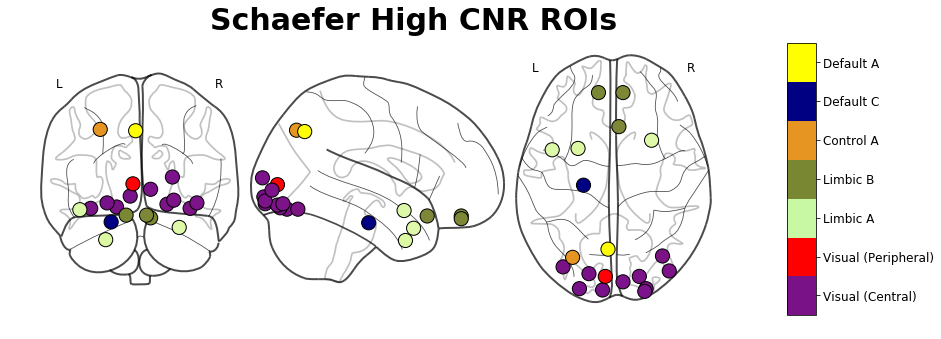

In [208]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 5), gridspec_kw={'width_ratios': [23/24, 1/24]})

plotting.plot_connectome(np.eye(schaeferbest_centroid_coords.shape[0]),
                         schaeferbest_info[["R", "A", "S"]].values,
                         node_color=[colors.to_hex(rgb / 255) for rgb in schaeferbest_info[["r", "g", "b"]].values],
                         node_size=200, node_kwargs={'edgecolors': "k"},
                         axes=axs[0])

# make the color bar
colors.ListedColormap(color_dict.values())
colorbar = mpl.colorbar.ColorbarBase(
    axs[1],
    cmap=colors.ListedColormap(color_dict.values()),
    orientation='vertical',
    boundaries=range(len(color_dict)+1))
r = float(len(color_dict))
colorbar.set_ticks([0.0 + r / int(r) * (0.5 + i) for i in range(int(r))])
colorbar.set_ticklabels(list(color_dict.keys()))
colorbar.ax.tick_params(labelsize=12)

fig.suptitle("Schaefer High CNR ROIs", size=30, weight="heavy");

save_eps(fig, "./outputs/schaefer_high_cnr_rois")

CNR/CVNR for the schaefer atlas is significantly greater in the null data relative to the real data.

CNR/CVNR for the activation atlas was not found to be significantly different between the null and real data.

This could explain the greater number of false positives found in the Null data relative to the real data in the Schaefer atlas.

The activation atlas null data, however, should be representative of the real data.

## PLAYGROUND